# <center> Study Project-6: Clusterization

### <center> Customer segmentation based on their purchasing power: Gift Shop
<center> <img src=https://salesupnow.ru/storage/app/media/pipeople.png align="center" width="300"/> </center>

**Business Task**:
To group customers with similar purchasing power together.

*It`s the main step to develop further tailored marketing and sales strategies for each segment and improve their overall performance.*

**Technical Task**
* Using the data to build a clusterization model based on customers` purchasing power, order quantity and statute of limitations for last purchase. Define profile of each cluster.

**Type of ML task**
* Clusterization -> Classification

**Metrics:** Accuracy

**Data:** The csv file contains 541 909 records and 8 columns


# <p style="text-align:center;font-size:100%;">0. Install and Import</p>

In [1]:
# Import libs
import pandas as pd
import numpy as np

# Libs for visualization
import plotly.express as px
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from plotly.subplots import make_subplots

from datetime import datetime

# Models
from sklearn import mixture
from sklearn import manifold
from sklearn import pipeline
from sklearn import preprocessing
from sklearn import cluster
from sklearn import metrics
from sklearn import model_selection
from sklearn import decomposition
from sklearn import ensemble
from sklearn.pipeline import Pipeline

import warnings 
from IPython.display import display, HTML

warnings.filterwarnings('ignore')

plt.rcParams['patch.force_edgecolor'] = True

In [2]:
# Fixing RANDOM_SEED to make experiment repetable
RANDOM_SEED = 42

# Fixing package versions to make experiment repetable
!pip freeze > requirements.txt

In [3]:
# Load datasets
data = pd.read_csv(
    'data/customer_segmentation_project.csv',
    encoding='ISO-8859-1'
)

***

## <center> 1. Checking dataset: outliers, duplicates

Let's read the dataset into the DataFrame *data* and will have a look at the *shape, columns, column data types and the first 5 rows of the data*. This will give a brief overview of the data at hand.

In [4]:
# Reading csv-file
print(f'Data shape: {data.shape}')

display(data.head())
display(data.info())

Data shape: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


None

***

### `Exploring the content of variables`

The dataset is dedicated to the customers information and contains 541_909 rows and 8 columns
The Variables correspond to:

* *InvoiceNo*: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.

* *StockCode*: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.

* *Description*: Product (item) name. Nominal.

* *Quantity*: The quantities of each product (item) per transaction. Numeric.

* *InvoiceDate*: Invoice Date and time. Numeric, the day and time when each transaction was generated.

* *UnitPrice*: Unit price. Numeric, Product price per unit in sterling.

* *CustomerID*: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.

* *Country*: Country name. Nominal, the name of the country where each customer resides.

In [5]:
"""
Define Unique categories in each column
"""
unique_list = []

for col in data.columns:
    # creating tuple: column name, number of unique values, type
    item = (col, data[col].nunique(), data[col].dtypes, data[col].unique())
    unique_list.append(item)
    
unique_counts = pd.DataFrame(
    unique_list,
    columns=['Column_Name', 'Num_Unique', 'Type', 'Unique_category']
).sort_values(by='Num_Unique', ignore_index=True)


display(unique_counts)

,Column_Name,Num_Unique,Type,Unique_category
0,Country,38,object,"[United Kingdom, France, Australia, Netherland..."
1,Quantity,722,int64,"[6, 8, 2, 32, 3, 4, 24, 12, 48, 18, 20, 36, 80..."
2,UnitPrice,1630,float64,"[2.55, 3.39, 2.75, 7.65, 4.25, 1.85, 1.69, 2.1..."
3,StockCode,4070,object,"[85123A, 71053, 84406B, 84029G, 84029E, 22752,..."
4,Description,4223,object,"[WHITE HANGING HEART T-LIGHT HOLDER, WHITE MET..."
5,CustomerID,4372,float64,"[17850.0, 13047.0, 12583.0, 13748.0, 15100.0, ..."
6,InvoiceDate,23260,object,"[12/1/2010 8:26, 12/1/2010 8:28, 12/1/2010 8:3..."
7,InvoiceNo,25900,object,"[536365, 536366, 536367, 536368, 536369, 53637..."


Some observations about the data:

* Number of countries from which orders were made: 38
* Number of unique products: 4070
* Number of Description for each product: 4223
    - *This difference looks interesting because number of Description is more than number of unique products*
* Number of unique customers: 4372

In [6]:
"""
Let's look at the numerical columns
"""
round(data.describe(), 2)

,Quantity,UnitPrice,CustomerID
count,541909.00,541909.00,406829.00
mean,9.55,4.61,15287.69
std,218.08,96.76,1713.60
min,-80995.00,-11062.06,12346.00
25%,1.00,1.25,13953.00
50%,3.00,2.08,15152.00
75%,10.00,4.13,16791.00
max,80995.00,38970.00,18287.00


Some observations about the data:

* There is column with missing data - CustomerID
* The number of product Quantity varies between **-80995** and **80995** with most number being 3 or 10
* The Unit Price varying from **-11062.06** to **38970**. There are definitely some outliers present which must be treated.

In [7]:
"""
Let's look at the non numerical columns
"""
data.describe(include='object')

,InvoiceNo,StockCode,Description,InvoiceDate,Country
count,541909,541909,540455,541909,541909
unique,25900,4070,4223,23260,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,10/31/2011 14:41,United Kingdom
freq,1114,2313,2369,1114,495478


Some observations about the data:

* There is column with missing values - Description
* The most customers are from United Kingdom
* The most popular number of transaction: 573585 (0,21%)
* The most popular product: 85123A (0,43%) *(Description: WHITE HANGING HEART T-LIGHT HOLDER)*

***

### `InvoiceDate`

In [8]:
# Convert 'InvoiceDate' column to datetime type
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'], format='%m/%d/%Y %H:%M')

# Check: Look at the last and first time of purchase
print(f'Last time (yyyy-mm-dd): {data.InvoiceDate.max()}')
print(f'First time (yyyy-mm-dd): {data.InvoiceDate.min()}')

Last time (yyyy-mm-dd): 2011-12-09 12:50:00
First time (yyyy-mm-dd): 2010-12-01 08:26:00


In [9]:
print(f'Maximum products quantity in order: {data.Quantity.max()}')
print(f'Minimum products quantity in order: {data.Quantity.min()}')
print('The most cheap product (except of products with negative price): ')
display(data[data['UnitPrice'] >= 0]['UnitPrice'].min())

Maximum products quantity in order: 80995
Minimum products quantity in order: -80995
The most cheap product (except of products with negative price): 


0.0

As you can see, there are 2 transactions with more than **80 thousand products quantity** - positive and negative values (probably, it's situation of cancelled order).

Moreover there are cases with **0 price** for product.

We need to explore these cases in details.

In [10]:
print(f'Number of unique customers: {data.CustomerID.nunique()}')

print('Number of unique countries: {}'.format(data[data['Country'] != 'Unspecified']['Country'].nunique())) # except of 'Unspecified' tag

print(f'ID number of the most popular product: {data.StockCode.value_counts()[0]}')

Number of unique customers: 4372
Number of unique countries: 37
ID number of the most popular product: 2313


***

# <p style="text-align:center;font-size:100%;">2. Data preprocessing and cleaning</p>

In [11]:
# Make a copy
data_market = data.copy()

### `Missing Values`

In [12]:
"""
Let`s check our data for Missing values (MV)
"""
print(f'Total number of rows, columns: {data_market.shape}')

# duplicates
all_columns = list(data_market.columns)
mask_dupl = data_market.duplicated(subset=all_columns) 
data_duplicates = data_market[mask_dupl]
print(f'\nNumber of found duplicates: {data_duplicates.shape[0]}')

# features with missing values
nulls_data = data_market.isnull().sum()
nulls = nulls_data[nulls_data > 0]
print(f'\nFeatures with nulls: {nulls_data[nulls_data>0].count()}\n{nulls}')

Total number of rows, columns: (541909, 8)

Number of found duplicates: 5268

Features with nulls: 2
Description      1454
CustomerID     135080
dtype: int64


There are missing values in 2 columns:
- Description (0.27%)
- CustomerID (~25%)

It indicates that the transactions are incorrect or incomplete.

Let's delete rows with Missing Values.

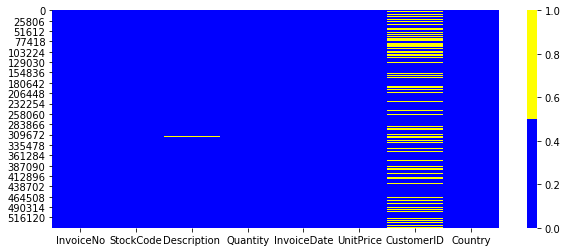

In [13]:
"""
Distribution of Missing Values according to the data
"""
cols_with_null = data_market.isnull().sum()

colors = ['blue', 'yellow']

fig = plt.figure(figsize=(10,4))
cols = cols_with_null.index
ax = sns.heatmap(
    data_market[cols].isnull(),
    cmap=sns.color_palette(colors)
)

The graph shows that the concentrations of Missing Values on the "Description" feature are included in the gaps on the "CustomerID" feature.

It will be enough to delete rows with MV in CustomerID column.

In [14]:
# Delete rows with Missing Values
data_market = data_market.dropna(how='any', axis=0)
data_market.shape

(406829, 8)

### `Duplicates`

Let's check number of duplicates after deleting rows with Missing Values

In [15]:
all_columns = list(data_market.columns)
mask_dupl = data_market.duplicated(subset=all_columns) 
data_duplicates = data_market[mask_dupl]

print(f'\nNumber of found duplicates: {data_duplicates.shape[0]}')


Number of found duplicates: 5225


In [16]:
# Delete duplicates
data_market = data_market.drop_duplicates(subset=all_columns)
print(f'Final number of rows: {data_market.shape[0]}')

Final number of rows: 401604


***

### `Quantity of product`

This column consists of negative values. Let's look at it in details.

In [17]:
negative_quantity = data_market[(data_market['Quantity']<0)]

print('Count of entries with a negative number: {}'.format(negative_quantity.shape[0]))
negative_quantity.head()

Count of entries with a negative number: 8872


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom


There are about 9 thousand cases (2,2%) with negative value of Quantity. It doesn't look like as a mistake.

Some observations about the data:

* Order number (InvoiceNo) and product id (StockCode) are contained numeric values and symbols
* Product ID contains different special symbols
* Each column for each transaction history

Let's check: all records with a negative quantity of products are indeed reverse transactions.

If the transaction is not a return, but contains a negative quantity of goods, this will be considered as an outlier.

In [18]:
"""
Number of transactions without "C" symbol (cancelletion)
"""
def get_number_not_C(invoice_number):
    i = 0
    for number in invoice_number:
        if 'C' not in number:
            i += 1
    return i
    
    
get_number_not_C(negative_quantity['InvoiceNo'])

0

All transactions with negative quantity of goods are returns.

Let's take a closer look at returns. Now, each unique product has a separate line in the table, which makes it difficult to determine the total number of returns.

To count the number of returns, it's necessary to determine the number of products purchased in every transaction

In [19]:
temp = data_market.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket[:10].sort_values('CustomerID')

,CustomerID,InvoiceNo,Number of products
0,12346.0,541431,1
1,12346.0,C541433,1
2,12347.0,537626,31
3,12347.0,542237,29
4,12347.0,549222,24
5,12347.0,556201,18
6,12347.0,562032,22
7,12347.0,573511,47
8,12347.0,581180,11
9,12348.0,539318,17


The first lines of this list shows several things worthy of interest:

* the existence of entries with the prefix C for the InvoiceNo variable: this indicates transactions that have been canceled
* the existence of users who only came once and only purchased one product (e.g. #12346)
* the existence of frequent users that buy a large number of items at each order

In [20]:
"""
Let's check number of canceled orders
"""
nb_products_per_basket['order_canceled'] = nb_products_per_basket['InvoiceNo'].apply(lambda x: 1 if 'C' in x else 0)
display(nb_products_per_basket.head())

print(f'Percentage of canceled orders: {round(nb_products_per_basket.order_canceled.sum() / nb_products_per_basket.shape[0] * 100)} %')

,CustomerID,InvoiceNo,Number of products,order_canceled
0,12346.0,541431,1,0
1,12346.0,C541433,1,1
2,12347.0,537626,31,0
3,12347.0,542237,29,0
4,12347.0,549222,24,0


Percentage of canceled orders: 16 %


More than 16% of unique orders are returns.

In [21]:
# Let's look at the cancelled orders
nb_products_per_basket[nb_products_per_basket['order_canceled']==1].head()

,CustomerID,InvoiceNo,Number of products,order_canceled
1,12346.0,C541433,1,1
23,12352.0,C545329,2,1
24,12352.0,C545330,1,1
25,12352.0,C547388,7,1
39,12359.0,C549955,2,1


In [22]:
"""
Example: client with ID: 12346
"""
data_market[data_market['CustomerID'] == 12346]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346.0,United Kingdom


It is order-cancellation example.

* The next columns - StockCode, UnitPrice, CustomerID - are the same.
* Quantity column consists of positive and negative value of the same number.

**Hypothesis**: there is analogue with the same product code, CustomerID and the opposite value of the product quantity for each canceled transaction in the database.

In [23]:
returns = negative_quantity.copy()
returns.reset_index(inplace=True)

returns['Quantity'] = -returns['Quantity']

matched = pd.merge(returns, data_market,
                   on=['StockCode', 'CustomerID', 'Quantity'], how='inner')
matched.drop_duplicates(subset='index', inplace=True)
print(f'Number of mismatches: {negative_quantity.shape[0] - matched.shape[0]}')

Number of mismatches: 5626


**The hypothesis was not confirmed:** not all orders with a negative quantity of goods have their analogues in the table.

We need to further understand why this is happening.

In [24]:
"""
Counterexample: client with ID: 14527
"""
data_market[data_market['CustomerID'] == 14527].head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
8963,537159,22112,CHOCOLATE HOT WATER BOTTLE,6,2010-12-05 13:17:00,4.95,14527.0,United Kingdom
8964,537159,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-05 13:17:00,4.95,14527.0,United Kingdom
8965,537159,21479,WHITE SKULL HOT WATER BOTTLE,1,2010-12-05 13:17:00,3.75,14527.0,United Kingdom
8966,537159,22114,HOT WATER BOTTLE TEA AND SYMPATHY,6,2010-12-05 13:17:00,3.95,14527.0,United Kingdom


Some observations about the data:

* the first line - C536379 - has not analogue with the same product quantity
    - *reason*: this product has special StockCode - D - it means discount

**Hypothesis**: there is analogue with the same product code, CustomerID and the opposite value of the product quantity for each canceled transaction in the database if the product without discount.

In [25]:
stock_code_D_index = negative_quantity[negative_quantity['StockCode'] == 'D'].index
stock_code_D_index

neg_quantity_without_duscount = negative_quantity.drop(index=stock_code_D_index)
neg_quantity_without_duscount

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
238,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315.0,United Kingdom


In [26]:
returns = neg_quantity_without_duscount.copy()
returns.reset_index(inplace=True)

returns['Quantity'] = -returns['Quantity']

matched = pd.merge(returns, data_market,
                   on=['StockCode', 'CustomerID', 'Quantity'], how='inner')
matched.drop_duplicates(subset='index', inplace=True)
print(f'Number of mismatches: {neg_quantity_without_duscount.shape[0] - matched.shape[0]}')

Number of mismatches: 5549


**The hypothesis was not confirmed.**

We need to further understand why this is happening.

In [27]:
"""
Counterexample:
- client with ID: 15311
- product id: 35004C
"""
data_market[(data_market['CustomerID'] == 15311) & (data_market['StockCode'] == '35004C')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
9200,537195,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2010-12-05 13:55:00,4.65,15311.0,United Kingdom
18196,C537805,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-08 13:18:00,4.65,15311.0,United Kingdom
28630,538651,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2010-12-13 15:07:00,4.65,15311.0,United Kingdom
39381,C539640,35004C,SET OF 3 COLOURED FLYING DUCKS,-3,2010-12-20 15:27:00,4.65,15311.0,United Kingdom
44157,540157,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2011-01-05 11:41:00,4.65,15311.0,United Kingdom
59542,541293,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2011-01-17 13:39:00,4.65,15311.0,United Kingdom
78333,C542866,35004C,SET OF 3 COLOURED FLYING DUCKS,-2,2011-02-01 12:14:00,4.65,15311.0,United Kingdom


* On the first line we see an order with cancellation (the order number starts with a "C"). But there are no previous records of transactions associated with this client.

*The order for the purchase of this product from the client was received before December 2010, and this data is not in our table. This is a very common problem that arises in almost any work with transactions: there is only a fragment of the general data, but it is not known what preceded this fragment.*

* The next two lines show that the client can cancel not the whole order, but only part of it (on December 5, the client buys 12 units of goods, and on December 8, he issues a return for only 1 unit of goods). We must take this into account for the future.

Let's create new column: **QuantityCanceled** - quantity if cancalled orders after each transaction.

**We will not consider complex cases:**

* A canceled transaction does not have an opposite one (there was not a single purchase transaction for the refund transaction).
* The quantity of returned goods in the refund transaction is greater than the quantity of goods indicated in any of the individual purchase transactions (this is the case when the client made several orders of the same product, and then returned all the goods at once).

In [28]:
"""
Function to add new column - QuantityCanceled
- input: table with transactions
- output: column with quantity of cancelled orders
"""
def get_quantity_canceled(data):
    # Initialized Series (with nulls) of the same length as the columns of the table
    quantity_canceled = pd.Series(np.zeros(data.shape[0]), index=data.index)    
    negative_quantity = data[(data['Quantity'] < 0)].copy()
    for index, col in negative_quantity.iterrows():
        # Create DataFrame from all transactions opposite to returns
        df_test = data[(data['CustomerID'] == col['CustomerID']) &
                       (data['StockCode']  == col['StockCode']) & 
                       (data['InvoiceDate'] < col['InvoiceDate']) & 
                       (data['Quantity'] > 0)].copy()
        # The transaction-return has no opposite - do nothing
        if (df_test.shape[0] == 0): 
            continue
        # The transaction-return has only one opposite transaction
        # Adding the quantity of returned goods to the QuantityCanceled column
        elif (df_test.shape[0] == 1): 
            index_order = df_test.index[0]
            quantity_canceled.loc[index_order] = -col['Quantity']       
        # The return transaction has multiple opposite transactions
        # Enter the quantity of the returned goods in the QuantityCanceled column for the purchase transaction
        # in which the quantity of goods > (-1) * (the number of goods in the return transaction)
        elif (df_test.shape[0] > 1): 
            df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
            for ind, val in df_test.iterrows():
                if val['Quantity'] < -col['Quantity']: 
                    continue
                quantity_canceled.loc[ind] = -col['Quantity']
                break
            
    return quantity_canceled


data_market['QuantityCanceled'] = get_quantity_canceled(data_market)

In [29]:
print(f'Sum of canceled orders: {data_market.QuantityCanceled.sum()}')

Sum of canceled orders: 245266.0


In [30]:
"""
Delete records with negative values in Quantity column
"""
data_neg_quantity = data_market[data_market['Quantity'] < 0].index
data_market = data_market.drop(index = data_neg_quantity)
data_market.shape

(392732, 9)

***

### `Type od Transactions: StockCode`

In [31]:
"""
Using regular expressions in order to check type of transactions in StockCode column
"""

data_market['SpecialCode'] = data_market['StockCode'].str.contains('^[a-zA-Z]+', regex=True)

unique_symbols = []
for index, row in data_market.iterrows():
    if (row['SpecialCode'] is True) & (row['StockCode'] not in unique_symbols):
        unique_symbols.append(row['StockCode'])
        
unique_symbols

['POST', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT']

In [32]:
"""
Delete transactions with special codes
"""
data_market = data_market[data_market['SpecialCode'] == False]
data_market.shape

(391183, 10)

***

### `Product Price`

In [33]:
print(f'Number of transaction with price equals 0: {data_market[data_market.UnitPrice == 0].shape[0]}')

Number of transaction with price equals 0: 33


In [34]:
"""
Delete records with price equals or less than 0
"""
data_market = data_market[data_market['UnitPrice'] > 0]
data_market.shape

(391150, 10)

***

# <p style="text-align:center;font-size:100%;">3. Exploratory Data Analysis (EDA). Feature Engineering</p>

*Feature engineering is the process of transforming variables, and extracting and creating new variables from the original data points, to train machine learning models.*

Objectives:

* Customers from which countries buy more and more often
* Define seasonality in sales
* Creating new features

***

In [35]:
# Grouping data by unique customers
temp = data_market.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket.head()

,CustomerID,InvoiceNo,Number of products
0,12346.0,541431,1
1,12347.0,537626,31
2,12347.0,542237,29
3,12347.0,549222,24
4,12347.0,556201,18


In [36]:
"""
Chloropleth map:
- Number of orders per country
"""
country_df = pd.DataFrame(columns=['Country', 'Customers'])
countrys = sorted(data_market['Country'].unique())
for idx in range(len(countrys)):
    country = countrys[idx]
    new_row = {'Country':country, 'Customers':len(data_market[data_market['Country'] == country]['CustomerID'].unique())}
    country_df = country_df.append(new_row, ignore_index=True)

country_df['Customers'] = country_df['Customers'].astype('int')

fig = px.choropleth(
    country_df,
    locations='Country',
    locationmode='country names',
    scope='world',
    color='Customers',
    color_continuous_scale='spectral',
    title='Number of orders per country'
)

fig.update_layout(showlegend=True)
fig.write_image('plotly/choropleth_1.png')
# fig.show()

In [37]:
"""
Visualization:
- top-3 countries by orders quantity
"""
quantity_df = pd.DataFrame(columns=['Country', 'OrderNumber'])
countries = sorted(data_market['Country'].unique())
for idx in range(len(countries)):
    country = countries[idx]
    new_row = {'Country':country, 'OrderNumber':len(data_market[data_market['Country'] == country]['InvoiceNo'].unique())}
    quantity_df = quantity_df.append(new_row, ignore_index=True)

quantity_df['OrderNumber'] = quantity_df['OrderNumber'].astype('int')

fig = px.bar(quantity_df,
             x = 'Country',
             y = 'OrderNumber',
             barmode = 'group',
             title = 'Number of orders per country',
             template = 'ggplot2'
             )

fig.update_layout(showlegend=True)
fig.write_image('plotly/bar_2.png')
# fig.show()

In [38]:
"""
Add new column: TotalPrice
"""
data_market['TotalPrice'] = data_market['UnitPrice'] * (data_market['Quantity'] - data_market['QuantityCanceled'])
display(data_market.head())
print(f'Average total order value: {round(data_market.TotalPrice.mean())}')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,SpecialCode,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0.0,False,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0.0,False,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,0.0,False,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0.0,False,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0.0,False,20.34


Average total order value: 21


In [39]:
"""
Visualization:
- top-3 countries by total revenue
"""
total_df = pd.DataFrame(columns=['Country', 'TotalPrice'])
countries = sorted(data_market['Country'].unique())
for idx in range(len(countries)):
    country = countries[idx]
    new_row = {'Country':country, 'TotalPrice':sum(data_market[data_market['Country'] == country]['TotalPrice'].unique())}
    total_df = total_df.append(new_row, ignore_index=True)

fig = px.bar(total_df,
             x = 'Country',
             y = 'TotalPrice',
             barmode = 'group',
             title = 'Total Income per country',
             template = 'ggplot2'
             )

fig.update_layout(showlegend=True)
fig.write_image('plotly/bar_3.png')
# fig.show()

***

### `Time Features`

***

In [40]:
"""
Function to get 3 new time feautures:
- purchases_month - month of purchasing
- purchases_hour - hour of purchasing
- purchases_day_of_week - day of the week on which the customer make purchases
"""
def add_datetime_features(df):
    df['purchases_month'] = df['InvoiceDate'].dt.month
    df['purchases_hour'] = df['InvoiceDate'].dt.hour
    df['purchases_day_of_week'] = df['InvoiceDate'].dt.day_name()
    
    return df


add_datetime_features(data_market)

# Check
print('Number of Total Price in each month: ')
display(data_market.groupby(['purchases_month'], as_index=False)['TotalPrice'].sum().sort_values(by='TotalPrice', ascending=False))

Number of Total Price in each month: 


,purchases_month,TotalPrice
10,11,1119641.60
9,10,967436.46
8,9,928554.44
11,12,894126.86
4,5,647403.81
7,8,614704.38
5,6,601238.45
6,7,581019.35
2,3,571941.01
0,1,453560.68


Month with the higher Total income is November.

It is a time before Christmas and New Year celebration, when people look for presents.
*(This dataset describes data of gifts shop)*

In [41]:
print('Number of Total Price in each day: ')
display(data_market.groupby(['purchases_day_of_week'], as_index=False)['TotalPrice'].sum().sort_values(by='TotalPrice', ascending=False))

Number of Total Price in each day: 


,purchases_day_of_week,TotalPrice
3,Thursday,1888101.69
4,Tuesday,1552138.73
5,Wednesday,1535711.83
1,Monday,1300385.00
0,Friday,1219558.24
2,Sunday,767697.50


There is no any transactions in Saturday.

Probably this day is weekend for the shop or maybe it is a mistake.

In [42]:
"""
Create new feature:
- Date
"""
data_market['Date'] = data_market['InvoiceDate'].dt.date
purchases_by_date = data_market.groupby(['Date', 'purchases_hour'], as_index=False)['Quantity'].sum()

purchases_by_hour = purchases_by_date.groupby('purchases_hour', as_index=False)['Quantity'].mean().sort_values(by='Quantity', ascending=False)

fig = px.bar(purchases_by_hour,
             x = 'purchases_hour',
             y = 'Quantity',
             barmode = 'group',
             title = 'Quantity of orders (mean value) by each hour',
             template = 'ggplot2'
             )

fig.update_layout(showlegend=True)
fig.write_image('plotly/bar_4.png')
# fig.show()

Some observations about the data:

* Most orders are made during the day, between 10 am and 3 pm.
* Orders are not received from 9 pm to 6 am.

***

# <p style="text-align:center;font-size:100%;">4. RFM-customers segmentation. Part I</p>

The method consists in grouping clients based on the following parameters:

* Recency (Prescription) - prescription of the last purchase of the client;
* Frequency (Frequency) - the total number of customer purchases;
* Monetary Value - How much money the customer has spent.

The task of marketers is to lead the client to the zone of loyal ones.

***

In [43]:
"""
Create table with 3 features, grouped by Customer ID
- Recency
- Frequency
- Monetary
"""
now_date = datetime(2011, 12, 10)
rfm_table = pd.DataFrame(columns=['Recency', 'Frequency', 'Monetary'], index=sorted(data_market['CustomerID'].unique()))
for ind in rfm_table.index:
    rfm_table.loc[ind, 'Recency'] = (now_date - data_market[data_market.CustomerID == ind]['InvoiceDate'].max()).days
    rfm_table.loc[ind, 'Frequency'] = len(data_market[data_market.CustomerID == ind]['InvoiceNo'].unique())
    rfm_table.loc[ind, 'Monetary'] = data_market[data_market.CustomerID == ind]['TotalPrice'].sum()
    
rfm_table.index.rename('CustomerId', inplace= True)
rfm_table.head()

,Recency,Frequency,Monetary
CustomerId,,,
12346.0,325,1,0.0
12347.0,2,7,4310.0
12348.0,75,4,1437.24
12349.0,18,1,1457.55
12350.0,310,1,294.4


In [44]:
print('Number of clients made a purchase more than 200 days ago: {}.'.format(rfm_table[rfm_table.Recency > 200].shape[0]))
print('Average number of orders during one year: {}.'.format(round(rfm_table.Frequency.mean())))
print('Total amount of money spent by the client with id 12360: {}.'.format(round(rfm_table.loc[12360.0]['Monetary'])))

Number of clients made a purchase more than 200 days ago: 743.
Average number of orders during one year: 4.
Total amount of money spent by the client with id 12360: 2302.


In [45]:
boxes = [px.box(rfm_table, x=column) for column in rfm_table.columns]

fig = make_subplots(
    rows=1,
    cols=3,
    subplot_titles=('Recency','Frequency', 'Monetary')
    )

for i, box in enumerate(boxes):
    fig.add_trace(boxes[i]['data'][0], row=1, col=i+1)

fig.update_layout(showlegend=True)
fig.write_image('plotly/boxplot_5.png')
# fig.show()

Some observations about the data:

* There are customers with an abnormally high number of orders placed (more than 100).
* There are customers with total price of order more than 190 thousand

Outliers could make significant influence on the clusterization results.

In [46]:
"""
Delete outliers by quantile 0.95
"""
freq_q = rfm_table.Frequency.quantile(0.95)
monetary_q = rfm_table.Monetary.quantile(0.95)

rfm_table_cleaned = rfm_table[(rfm_table['Frequency'] <= freq_q) & (rfm_table['Monetary'] <= monetary_q)]
rfm_table_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 4044 entries, 12346.0 to 18287.0
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Recency    4044 non-null   object
 1   Frequency  4044 non-null   object
 2   Monetary   4044 non-null   object
dtypes: object(3)
memory usage: 126.4+ KB


In [47]:
boxes = [px.box(rfm_table_cleaned, x=column) for column in rfm_table_cleaned.columns]
fig = make_subplots(
    rows=1,
    cols=3, 
    subplot_titles=('Recency', 'Frequency', 'Monetary')
    )

for i, box in enumerate(boxes):
    fig.add_trace(boxes[i]['data'][0], row=1, col=i+1)

fig.update_layout(showlegend=True)
fig.write_image('plotly/boxplot_6.png')
# fig.show()

***

### `Clustering stage`

- evaluate the distribution of observations in the feature space (3-dimensional scatterplot: RFM)

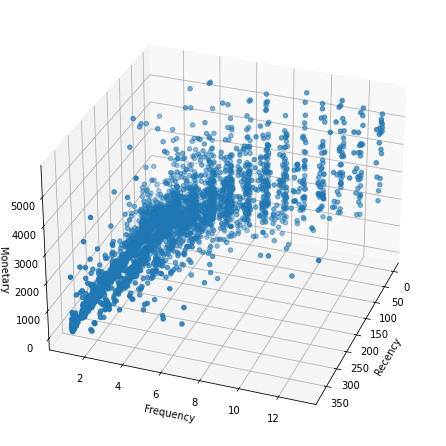

In [48]:
"""
Let's build a visualization of 3-dimensional feature space
"""
# create 3-d object
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)

# add an additional axis to the image object
fig.add_axes(ax)
ax.azim = 20
ax.elev = 30

# visualiztion: x, y, z, and information about grouping data by color
ax.scatter(
    rfm_table_cleaned['Recency'].to_list(), 
    rfm_table_cleaned['Frequency'].to_list(),
    rfm_table_cleaned['Monetary'].to_list()
)

# add axes
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary');

Some observations about the scatterplot:

* there are clients with large values of the Monetary and Frequency parameters
    * probably they are the best clients who buy most often and bring in the most money
* it is difficult to say how many clusters we have.

***

### `Dimensionality Reduction methods`

In [49]:
"""
Principal component analysis (PCA)
"""
# create pipeline
pipeline = Pipeline([('scaler', preprocessing.StandardScaler()),
                     ('pca', decomposition.PCA(n_components=2))])

# Training model
rfm_table_processed = pipeline.fit_transform(rfm_table_cleaned)

rfm_table_processed = pd.DataFrame(rfm_table_processed,
                                   columns=['axis-1', 'axis-2'],
                                   index=rfm_table_cleaned.index
                                   )

print(f'Number of components: {len(pipeline[1].components_)}')
print(f'Part of total variance in the original dataset is explained by the First principal component: {round(pipeline[1].explained_variance_ratio_[0], 2)}')

Number of components: 2
Part of total variance in the original dataset is explained by the First principal component: 0.68


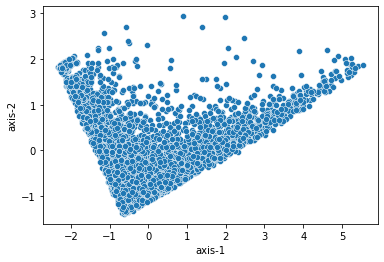

In [50]:
sns.scatterplot(data=rfm_table_processed, x='axis-1', y='axis-2');

,silhouette,cluster
0,0.500296,2
1,0.524230,3
2,0.497553,4
3,0.454544,5
4,0.448006,6
5,0.420295,7
6,0.420745,8
7,0.408957,9
8,0.397843,10


<AxesSubplot: xlabel='cluster', ylabel='silhouette'>

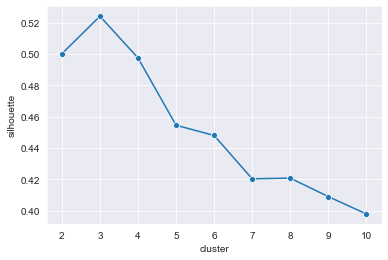

In [51]:
"""
Let's try to divide this space of principal components into segments
-  k-means method
"""
# create dict
silhouette_res = {'silhouette': [], 'cluster': []}

for i in range(2, 11):
    # training k_means model
    k_means = cluster.KMeans(n_clusters=i,
                             random_state=RANDOM_SEED
                             ).fit(rfm_table_processed)
    silhouette_res['silhouette'].append(metrics.silhouette_score(rfm_table_processed, k_means.labels_))
    silhouette_res['cluster'].append(i)
    
# save results in to df
silhouette_df = pd.DataFrame(silhouette_res)
display(silhouette_df)

# visualiztion style
sns.set_style('darkgrid')
sns.lineplot(data=silhouette_df, x='cluster', y='silhouette', marker= 'o')

* Maximum value of the silhouette coefficient for K-means: 0.52
* Optimal number of clusters: 3

,silhouette,cluster
0,0.342484,2
1,0.436061,3
2,0.350103,4
3,0.246969,5
4,0.266670,6
5,0.198851,7
6,0.196880,8
7,0.157627,9
8,0.109445,10


<AxesSubplot: xlabel='cluster', ylabel='silhouette'>

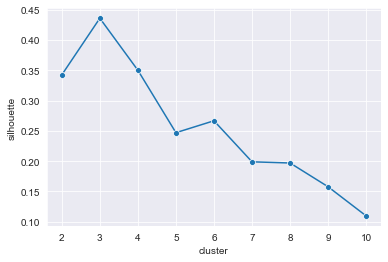

In [52]:
"""
Let's try to divide this space of principal components into segments
- EM-algorithm
"""
# create dict
silhouette_gm = {'silhouette': [], 'cluster': []}

for i in range(2, 11):
    # training k_means model
    gm = mixture.GaussianMixture(
        n_components=i,
        random_state=RANDOM_SEED
        ).fit_predict(rfm_table_processed)
    
    silhouette_gm['silhouette'].append(metrics.silhouette_score(rfm_table_processed, gm))
    silhouette_gm['cluster'].append(i)
    
# save results in to df
silhouette_gm_df = pd.DataFrame(silhouette_gm)
display(silhouette_gm_df)

# visualiztion style
sns.set_style('darkgrid')
sns.lineplot(data=silhouette_gm_df, x='cluster', y='silhouette', marker= 'o')

* Maximum value of the silhouette coefficient for EM-algorithm: 0.44
* Optimal number of clusters: 3

**The high value of the silhouette coefficient is for K-Means model.**

In [53]:
k_means = cluster.KMeans(n_clusters=3,
                         n_init=10,
                         random_state=RANDOM_SEED
                         )

k_means.fit(rfm_table_processed)

rfm_table_processed['KMeans_Cluster_ID'] = k_means.labels_
print(f'Number of customers in a big cluster: {rfm_table_processed.KMeans_Cluster_ID.value_counts()}')

Number of customers in a big cluster: 2    2269
0     999
1     776
Name: KMeans_Cluster_ID, dtype: int64


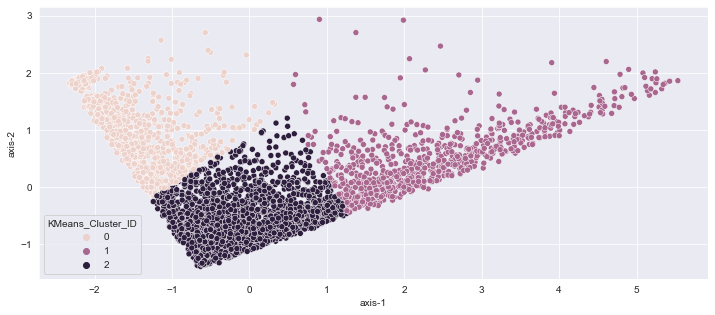

In [54]:
fig = plt.figure(figsize=(12, 5))
sns.scatterplot(
    data=rfm_table_processed, 
    x='axis-1', 
    y='axis-2', 
    hue='KMeans_Cluster_ID',
);

* There are 3 segments.

Let's create profile for each segment

In [55]:
"""
Create Profile:
* data: rfm_table_cleaned
* grouped rfm_table_cleaned by clusters
* calculate the average for each feature
"""
rfm_table_cleaned['KMeans_Cluster_ID'] = k_means.labels_

grouped_rfm = rfm_table_cleaned.groupby('KMeans_Cluster_ID').mean()
round(grouped_rfm)

,Recency,Frequency,Monetary
KMeans_Cluster_ID,,,
0,253.0,1.0,386.0
1,32.0,7.0,2658.0
2,51.0,2.0,660.0


### `Radar Chart for cluster's Profile visualization`

In [56]:
def plot_cluster_profile(grouped_data, n_clusters):
    # Normalised grouped data (0-1)
    scaler = preprocessing.MinMaxScaler()
    grouped_data = pd.DataFrame(scaler.fit_transform(grouped_data), columns=grouped_data.columns)
    # Create featutes list
    features = grouped_data.columns
    # Create empty fig
    fig = go.Figure()
    # Visualize Radar chat for each cluster
    for i in range(n_clusters):
        fig.add_trace(go.Scatterpolar(
            r=grouped_data.iloc[i].values, # raduis
            theta=features,
            fill='toself', # color
            name=f'Cluster {i}', # name — cluster's number
        ))
    # Update fig's parameters
    fig.update_layout(
        showlegend=True,
        autosize=False,
        width=800,
        height=800,
    )
    
    fig.write_image('plotly/Scatterpolar_{}.png'.format(n_clusters))
    # fig.show()
    
    
plot_cluster_profile(grouped_rfm, n_clusters=3)

* **Cluster 0:** "Loyal" customers - high-paying, frequent purchases, last purchase was not long time ago
* **Cluster 1:** "Lost" customers - low-paying, rare purchases, last purchase was long time ago
* **Cluster 2:** "Intermediate" customers - active, mean-paying, mean-value of purchases

***

# <p style="text-align:center;font-size:100%;">5. RFM-customers segmentation. Part II</p>

Usually customer segmentation task has objective to define more than 3 segments - some gradation from loyal to lost customers.

Let's use another type of Dimensionality Reduction method as non linear transformation - **t-SNE**

***

In [57]:
# deleting cluster labels from cleaned RFM-table (it could be the reason of leak data)
rfm_table_cleaned.drop('KMeans_Cluster_ID', axis = 1, inplace = True)

# create pipeline
pipeline = Pipeline(
    [('scaler', preprocessing.StandardScaler()),
     ('tsne', manifold.TSNE(n_components=2,
                            perplexity=50,
                            random_state=100))
     ]
    )

# Training pipeline
rfm_table_processed = pipeline.fit_transform(rfm_table_cleaned)
rfm_table_processed = pd.DataFrame(
    rfm_table_processed,
    columns = ['axis-1', 'axis-2']
)

print(f'Value of Kullback–Leibler divergence: {round(pipeline[1].kl_divergence_, 2)}')

Value of Kullback–Leibler divergence: 0.54


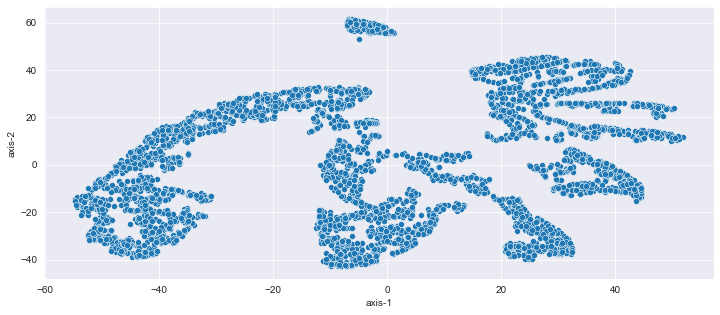

In [58]:
fig = plt.figure(figsize=(12, 5))
sns.scatterplot(data=rfm_table_processed, x='axis-1', y='axis-2');

The algorithm grouped the most similar objects into similar clusters, and these clusters are easy to identify.

,silhouette,cluster
0,0.434189,3
1,0.479278,4
2,0.478284,5
3,0.479196,6
4,0.484495,7
5,0.482026,8


<AxesSubplot: xlabel='cluster', ylabel='silhouette'>

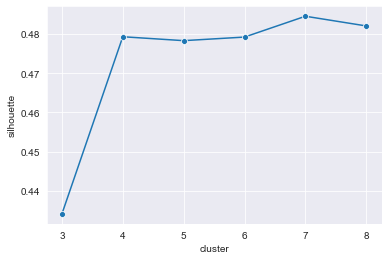

In [59]:
"""
Let's try to divide this space of principal components into segments
-  k-means method
"""
silhouette_res = {'silhouette': [], 'cluster': []}

for i in range(3, 9):
    # training k_means model
    k_means = cluster.KMeans(n_clusters=i,
                             random_state=RANDOM_SEED
                             ).fit(rfm_table_processed)
    
    silhouette_res['silhouette'].append(metrics.silhouette_score(rfm_table_processed, k_means.labels_))
    silhouette_res['cluster'].append(i)
    
# save results in to df
silhouette_df = pd.DataFrame(silhouette_res)
display(silhouette_df)

# visualiztion style
sns.set_style('darkgrid')
sns.lineplot(data=silhouette_df, x='cluster', y='silhouette', marker= 'o')

* Maximum value of the silhouette coefficient for K-means: 0.48
* Optimal number of clusters: 7

,silhouette,cluster
0,0.427071,3
1,0.468827,4
2,0.412347,5
3,0.457162,6
4,0.411883,7
5,0.429173,8


<AxesSubplot: xlabel='cluster', ylabel='silhouette'>

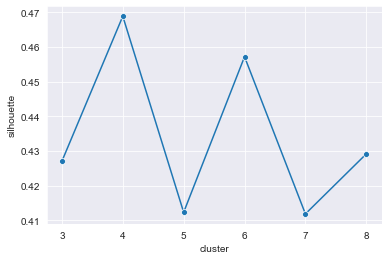

In [60]:
"""
Let's try to divide this space of principal components into segments
- EM-algorithm
"""
silhouette_gm = {'silhouette': [], 'cluster': []}

for i in range(3, 9):
    # training k_means model
    gm = mixture.GaussianMixture(
        n_components=i,
        random_state=RANDOM_SEED
        ).fit_predict(rfm_table_processed)
    
    silhouette_gm['silhouette'].append(metrics.silhouette_score(rfm_table_processed, gm))
    silhouette_gm['cluster'].append(i)
    
# save results in to df
silhouette_gm_df = pd.DataFrame(silhouette_gm)
display(silhouette_gm_df)

# visualiztion style
sns.set_style('darkgrid')
sns.lineplot(data=silhouette_gm_df, x='cluster', y='silhouette', marker= 'o')

* Maximum value of the silhouette coefficient for EM-algorithm: 0.47
* Optimal number of clusters: 4

,silhouette,cluster
0,0.379710,2
1,0.423116,3
2,0.456647,4
3,0.470394,5
4,0.469175,6
5,0.458636,7
6,0.479046,8


<AxesSubplot: xlabel='cluster', ylabel='silhouette'>

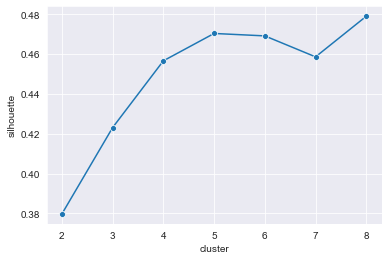

In [61]:
"""
Let's try to divide this space of principal components into segments
- Agglomerative Clustering
"""
silhouette_agg = {'silhouette': [], 'cluster': []}

for i in range(2, 9):
    # training k_means model
    aggl = cluster.AgglomerativeClustering(
        n_clusters=i
        ).fit_predict(rfm_table_processed)
    
    silhouette_agg['silhouette'].append(metrics.silhouette_score(rfm_table_processed, aggl))
    silhouette_agg['cluster'].append(i)
    
# save results in to df
silhouette_agg_df = pd.DataFrame(silhouette_agg)
display(silhouette_agg_df)

# visualiztion style
sns.set_style('darkgrid')
sns.lineplot(data=silhouette_agg_df, x='cluster', y='silhouette', marker= 'o')

* Maximum value of the silhouette coefficient for Agglomerative Clustering: 0.48
* Optimal number of clusters: 8

In [62]:
k_means = cluster.KMeans(n_clusters=7,
                         n_init=10,
                         random_state=RANDOM_SEED
                         )

k_means.fit(rfm_table_processed)

rfm_table_processed['KMeans_Cluster_ID'] = k_means.labels_
print(f'Number of customers in a big cluster: {rfm_table_processed.KMeans_Cluster_ID.value_counts()}')

Number of customers in a big cluster: 1    914
4    683
0    656
2    543
5    446
6    405
3    397
Name: KMeans_Cluster_ID, dtype: int64


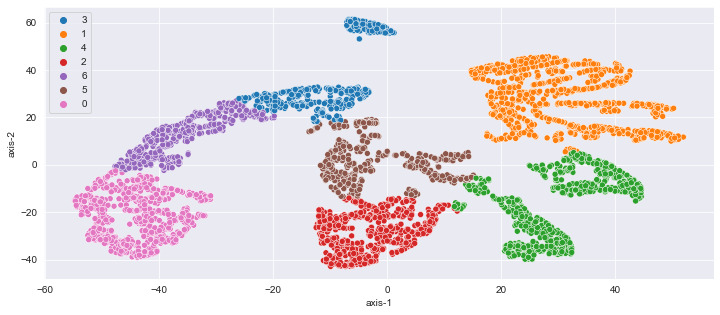

In [63]:
fig = plt.figure(figsize=(12, 5))
sns.scatterplot(data=rfm_table_processed, x='axis-1', y='axis-2', hue=k_means.labels_.astype('str'));

* There are 7 segments.

Let's create profile for each segment

In [64]:
"""
Create Profile:
* data: rfm_table_cleaned
* grouped rfm_table_cleaned by clusters
* calculate the average for each feature
"""
rfm_table_cleaned['KMeans_Cluster_ID'] = k_means.labels_

grouped_rfm = rfm_table_cleaned.groupby('KMeans_Cluster_ID').mean()
round(grouped_rfm)

print(f'Max value for Recency column (days number): {grouped_rfm.Recency.max()}')

Max value for Recency column (days number): 313.0


In [65]:
plot_cluster_profile(grouped_rfm, n_clusters=7)

* **Cluster 0:** "Newbie" clients - first purchase for not high price, few days ago
* **Cluster 1:** "Loyal" customers - high-paying, frequent purchases, last purchase was not long time ago
* **Cluster 2:** "Loose" customers - a few purchases for not high price, few days ago
* **Cluster 3:** "Lost" customers - low-paying, rare purchases, last purchase was more than one year ago
* **Cluster 4:** "Promising" clients - active, mean-paying, mean-value of purchases
* **Cluster 5:** Customers at "risk zone" - a few purchases for not high price, last purchase was more than 5 months ago
* **Cluster 6:** "Sleeping" customers - make 1 order for low price more than 5 months ago

***

# <p style="text-align:center;font-size:100%;">6. RFM-customers segmentation. Part III. Classification model</p>

Now we have true clusters labels.

In order to make prediction for new data it's needed to change task from **clusterization** to **classification**.

***

In [66]:
X = rfm_table_cleaned.drop(columns='KMeans_Cluster_ID', axis=1) #cleaned RFM-table
y = rfm_table_cleaned['KMeans_Cluster_ID'] #cluster's label

# dividing for train and validation data (80/20) - hold-out validation
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
display(X_train.shape[0], X_test.shape[0])

3235

809

T-SNE - non linear method. That's why it has more sense to use non linear models:
* Ensemlbe (Random Forest)

In [67]:
"""
Ensemble: Random Forest model
"""

param_grid = {
    'max_depth': range(5, 15),
    'criterion': ['gini', 'entropy'],
    'n_estimators': [100, 200, 500]
}

grid_search_forest = model_selection.GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=RANDOM_SEED),
    param_grid=param_grid,
    cv=5,
    n_jobs = -1
)

# Model training
%time grid_search_forest.fit(X_train, y_train)

# Get prediction
y_train_pred = grid_search_forest.predict(X_train)
y_test_pred = grid_search_forest.predict(X_test)

# Computing metrics
print('Accuracy on train data: {:.3f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('\nAccuracy on test data: {:.3f}'.format(metrics.accuracy_score(y_test, y_test_pred)))
print('\nThe best values of hyperparameters: {}'.format(grid_search_forest.best_params_))

Wall time: 1min 56s
Accuracy on train data: 1.000

Accuracy on test data: 0.985

The best values of hyperparameters: {'criterion': 'gini', 'max_depth': 13, 'n_estimators': 200}


Accuracy score is high, but we can try one more model - **Boosting** - in order to check final result.

In [68]:
"""
Boosting
"""
model_for_gs = ensemble.GradientBoostingClassifier(random_state=RANDOM_SEED)

param_grid = {
    'max_depth': range(3, 7),
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [100, 200, 500]
}

grid_search_gs = model_selection.GridSearchCV(model_for_gs,
                                              param_grid,
                                              cv=5,
                                              scoring=metrics.make_scorer(metrics.accuracy_score),
                                              n_jobs = -1)

# Model training 
grid_search_gs.fit(X_train, y_train)

# Get prediction
y_train_pred = grid_search_gs.predict(X_train)
y_test_pred = grid_search_gs.predict(X_test)

# Computing metrics
print(f'The best values of hyperparameters:{grid_search_gs.best_params_}')
print(f'The best values of metrics:{grid_search_gs.best_score_}')
print('\nAccuracy on test data: {:.3f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

The best values of hyperparameters:{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200}
The best values of metrics:0.9860896445131375

Accuracy on test data: 0.983


In [69]:
result = pd.DataFrame({
    'Model Name': ['Random Forest Classifier', 'Gradient Boosting'],
    'Hyperparameters': ['criterion=gini, max_depth=13, n_estimators=200',
                        'learning_rate=0.1, max_depth=4, n_estimators=200'],
    'Accuracy, train': ['1.000', '1.000'],
    'Accuracy, test': ['0.985', '0.983']
})

display(result)

,Model Name,Hyperparameters,"Accuracy, train","Accuracy, test"
0,Random Forest Classifier,"criterion=gini, max_depth=13, n_estimators=200",1.000,0.985
1,Gradient Boosting,"learning_rate=0.1, max_depth=4, n_estimators=200",1.000,0.983


***

Further study:

* Select wholesalers in a separate segment. Create RFMQ-table, where "Q" - mean quantity of products in one order.
* Cluster analysis of goods based on their description. Create categories for which purchases are made.
* Calculate the purchase frequency of each product category for each customer (segmentation by customers' interest)
* Seasonality of purchases. Define **regular customers** and **seasonal customers**

***